In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

In [2]:
def L_D_W_matrices(X, sigma = 1):
    #Input: a numpy array where each row houses the coordinates of a datapoint
    #and each column i houses the i coordinate.
    #Optional input: sigma; controls the width of neighborhoods.
    #Output: the Laplacian matrix L computed using the Euclidean norm and Gaussian
    #similarity function and the diagonal matrix D.

    #N = number of data points
    N = np.shape(X)[0]

    #Pairwise euclidean distances between all data points
    distances = euclidean_distances(X, X)

    #Compute the similarity matrix using the Gaussian similarity kernel
    gamma = 1.0 / (2 * sigma ** 2)
    W = np.exp(-gamma * distances ** 2)

    D = np.diag(np.sum(W, axis = 1))

    L = D - W

    return L, D, W

In [3]:
#Spectral Clustering using Unnormalized Grid Laplacian
def unnormalized_spectral_clustering(X, k, sigma = 1):
    #Input: a numpy array where each row houses the coordinates of a datapoint
    #and each column i houses the i coordinate and k, the number of clusters
    #to group the data into.
    #Optional input: sigma; controls the width of neighborhoods.
    #Output: the cluster assignments of the data computed using the unnormalized grid laplacian.
    L, D, _ = L_D_W_matrices(X, sigma)

    N = np.shape(X)[0]

    evals, evecs = eig(L)
    
    idx = np.argsort(evals.real)
    elvas = evals[idx]
    evecs = evecs[:,idx]

    #Construct the matrix V which houses the k eigenvectors
    #associated to the smallest eigenvalues.
    V = evecs[:, :k]
    
    #Perform kmeans clustering on V
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(V)

    #Display the clustered data
    plt.scatter(X[:,0], X[:,1], c=kmeans.labels_)
    plt.show()

    return kmeans.labels_

In [4]:
#Spectral Clustering using Normalized Grid Laplacian (L_{rw} = I-D^{-1}W)
def normalized_spectral_clustering(X, k, sigma = 1):
    #Input: a numpy array where each row houses the coordinates of a datapoint
    #and each column i houses the i coordinate and k, the number of clusters
    #to group the data into.
    #Optional input: sigma; controls the width of neighborhoods.
    #Output: the cluster assignments of the data computed using the normalized grid laplacian.
    L, D, _ = L_D_W_matrices(X, sigma)

    N = np.shape(X)[0]

    #Solve the generalized eigenvector problem Lv = lambda Dv
    #These eigenvectors are the eigenvectors of I-D^{-1}W
    evals, evecs = eig(L, D)
    #Sort evals and evecs with evals increasing
    idx = np.argsort(evals.real)
    elvas = evals[idx]
    evecs = evecs[:,idx]

    #Construct the matrix V which houses the k eigenvectors
    #associated to the smallest eigenvalues.
    V = evecs[:, :k]

    #Perform kmeans clustering on V
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(V)

    #Display the clustered data
    plt.scatter(X[:,0], X[:,1], c=kmeans.labels_)
    plt.show()

    return kmeans.labels_


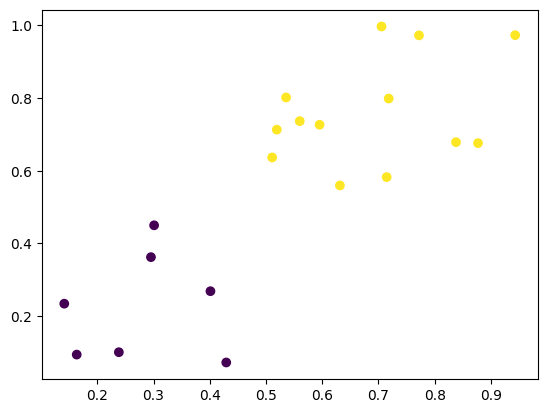

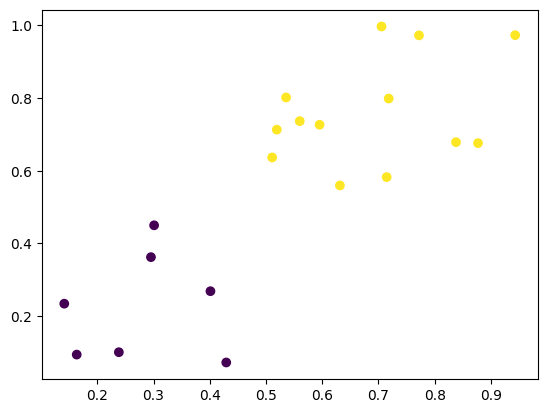

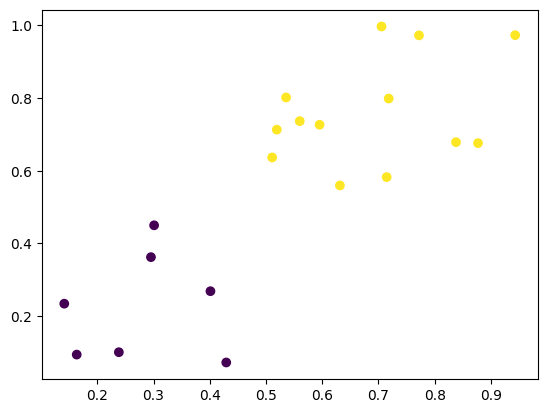

In [5]:
#Generate some data points in the x-y plane where each cluster is drawn
#from a random uniform over a box with diagonal along the line y = x.

#True number of underlying clusters
d = 2 

#Assuming that each cluster is evenly spaced along the line y = x
partitions = list(np.linspace(0, 1, d + 1))

#True probability that the data is generated by each class
categorical_weights = np.random.uniform(0, 1, 2)
categorical_weights = categorical_weights/np.sum(categorical_weights)

x = []
y = []
true_cluster = []

#Number of points, number of rows in matrices
N = 20 

#Generating sample points
for i in np.arange(N):
    #First determine which true cluster is generating the sample
    category_sample = np.random.uniform()
    temp = sorted(list(np.cumsum(categorical_weights)) + [category_sample])
    category_index = list(temp).index(category_sample)
    true_cluster += [category_index]
    
    #Then generate the point
    x += [np.random.uniform(partitions[category_index], partitions[category_index + 1])]
    y += [np.random.uniform(partitions[category_index], partitions[category_index + 1])]     

plt.scatter(x, y, c = true_cluster)
plt.show()
X = np.column_stack((x, y))
unnormalized_labels = unnormalized_spectral_clustering(X, 2)
normalized_labels = normalized_spectral_clustering(X, 2)

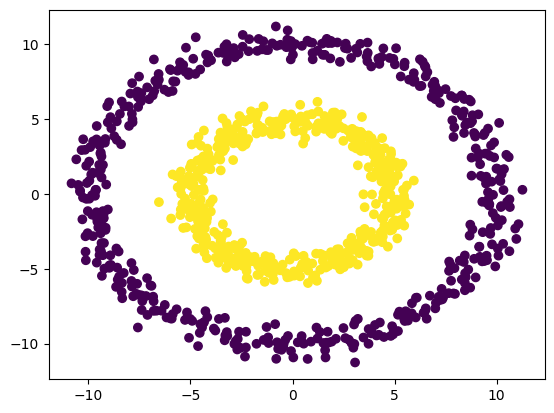

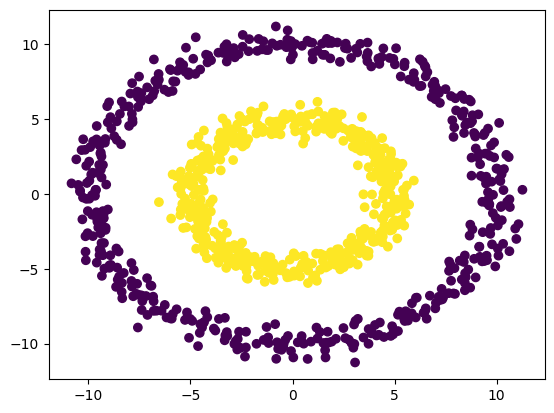

In [6]:
#Generate data points to form two concentric circles in the x-y plane.
def generate_concentric_circles_with_noise(num_points, inner_radius, outer_radius, noise_level):
    # Generate points for the inner circle
    theta_inner = np.linspace(0, 2 * np.pi, num_points)
    x_inner = inner_radius * np.cos(theta_inner)
    y_inner = inner_radius * np.sin(theta_inner)

    # Generate points for the outer circle
    theta_outer = np.linspace(0, 2 * np.pi, num_points)
    x_outer = outer_radius * np.cos(theta_outer)
    y_outer = outer_radius * np.sin(theta_outer)

    # Add noise to both sets of points
    x_inner += np.random.normal(0, noise_level, size=num_points)
    y_inner += np.random.normal(0, noise_level, size=num_points)
    x_outer += np.random.normal(0, noise_level, size=num_points)
    y_outer += np.random.normal(0, noise_level, size=num_points)

    return x_inner, y_inner, x_outer, y_outer

# Parameters for the circles
num_points = 500
inner_radius = 5
outer_radius = 10
noise_level = 0.5

# Generate concentric circles with noise
x_inner, y_inner, x_outer, y_outer = generate_concentric_circles_with_noise(num_points, inner_radius, outer_radius, noise_level)

# Combine the points
X = np.vstack((np.column_stack((x_inner, y_inner)), np.column_stack((x_outer, y_outer))))

unnormalized_labels = unnormalized_spectral_clustering(X, 2, noise_level)
normalized_labels = normalized_spectral_clustering(X, 2, noise_level)

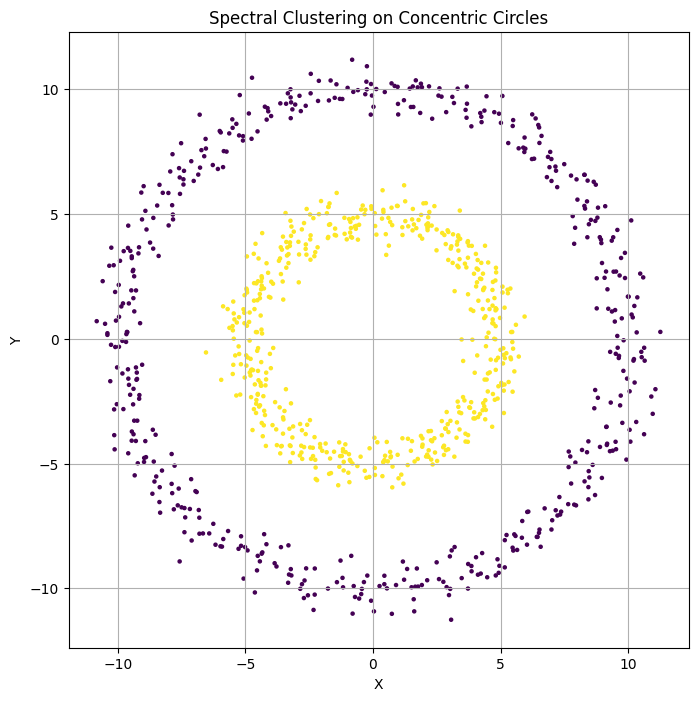

In [7]:
#Use the built-in function SpectralClustering to perform clustering on the same set of data points.
spectral_clustering = SpectralClustering(n_clusters=2, affinity='precomputed', random_state=0)

_, _, W = L_D_W_matrices(X, noise_level) 
labels = spectral_clustering.fit_predict(W)

# Plot the points with cluster assignments
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
plt.title('Spectral Clustering on Concentric Circles')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

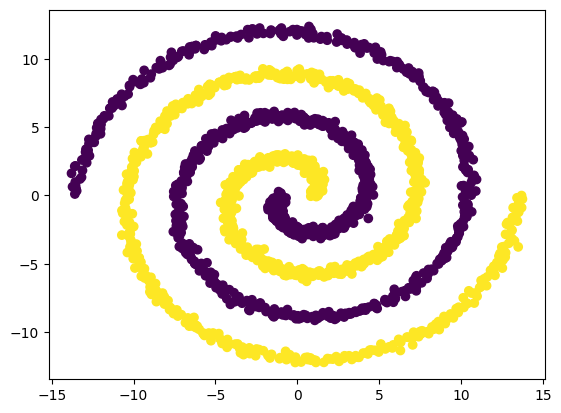

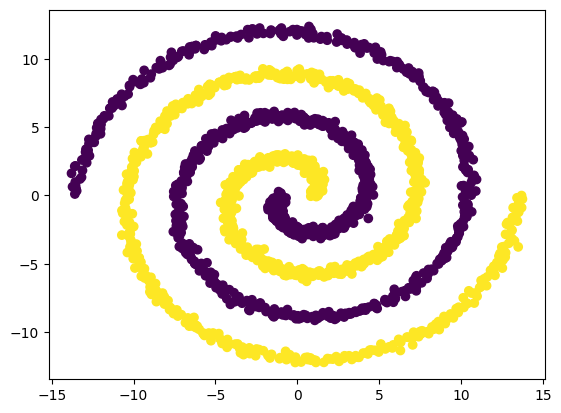

In [10]:
#Generate data points to form two interlacing spirals in the x-y plane.
def generate_spiral_points_with_noise(theta, a, b, offset, noise_level):
    x = (a + b * theta) * np.cos(theta + offset) + np.random.normal(0, noise_level, size=theta.shape)
    y = (a + b * theta) * np.sin(theta + offset) + np.random.normal(0, noise_level, size=theta.shape)
    return x, y

# Number of points for each spiral
num_points = 1000

# Parameters for the spirals
a = 1
b = 1

# Noise level: controls amount of noise added to spiral points
noise_level = 0.2

# Generate points for the first spiral with noise
theta1 = np.linspace(0, 4 * np.pi, num_points)
offset1 = 0
x1, y1 = generate_spiral_points_with_noise(theta1, a, b, offset1, noise_level)

# Generate points for the second spiral with noise
theta2 = np.linspace(0, 4 * np.pi, num_points)
offset2 = np.pi  # Offset by pi to interlace the spirals
x2, y2 = generate_spiral_points_with_noise(theta2, a, b, offset2, noise_level)

# Combine the points
X = np.vstack((np.column_stack((x1, y1)), np.column_stack((x2, y2))))

unnormalized_labels = unnormalized_spectral_clustering(X, 2, noise_level)
#CAUTION: The by-hand normalized spectral clustering takes a long time for this problem.
normalized_labels = normalized_spectral_clustering(X, 2, noise_level)

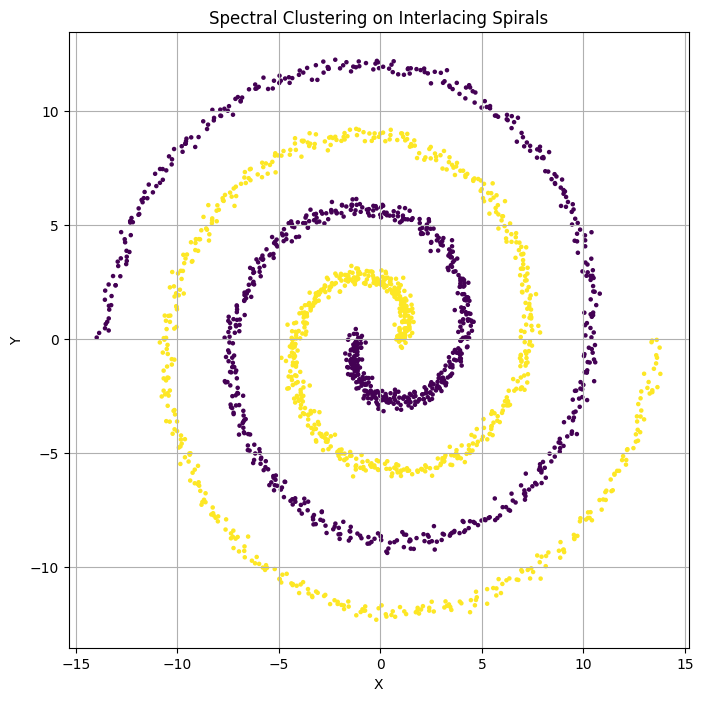

In [9]:
#Use the built-in function SpectralClustering to perform clustering on the same set of data points.
_, _, W = L_D_W_matrices(X, noise_level) 
#CAUTION: The built-in function spectral clustering takes a long time for this problem.
labels = spectral_clustering.fit_predict(W)

# Plot the points with cluster assignments
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
plt.title('Spectral Clustering on Interlacing Spirals')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()